In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")

# Posterior Predictive Checking

## Objectives

+ Introduce the concept of posterior predictive checking

## Posterior Predictive Checking

Assume that we have built a model using some data, say $x_{1:n}$.
Now, assume that you do the experiment again under the same conditions.
What data does your model tell you that you would observe?
The posterior predictive distribution of the *replicated data* $x^{\text{rep}}_{1:n}$ is simply:

$$
p(x^{\text{rep}}_{1:n}|x_{1:n}) = \int p(x^{\text{rep}}_{1:n}|\theta)p(\theta|x_{1:n})d\theta,
$$

where $p(x^{\text{rep}}_{1:n}|\theta)$ is just the likelihood and $p(\theta|x_{1:n})$ the posterior.
The idea of *posterior predictive checking* is to repeatedly sample $x^{\text{rep}}_{1:n}$ and compare their characteristics to the true data.
You may reject a model that performs very poorly under predictive checking.
However, you cannot accept a model that performs very well.
There are other methods for doing this which are more involved.
Predictive checking is good for identifying bugs in your code or coming up with ideas to extend the models in a way that better matches the data.

## Visual Inspections of Replicated Data

The idea here is to simply sample $x^{\text{rep}}_{1:n}$ and compare it visually to $x_{1:n}$.
Let's see this on the coin toss example.

## Demonstration with the Coin Toss Example

Consider $n$ coin-tosses with probability of heads ($1$) $\theta$, i.e.,

$$
x_{i}|\theta \sim \operatorname{Ber}(\theta).
$$

We put a uniform prior on $\theta$:

$$
\theta\sim U([0,1]),
$$

and we have already seen that the posterior is a Beta:

$$
\theta|x_{1:n} \sim \operatorname{Beta}\left(1 + \sum_{i=1}^nx_i, 1 + n - \sum_{i=1}^nx_i\right).
$$

Now, it is actually possible to get $p(x^{\text{rep}}_{1:n} | x_{1:n})$ analytically in this case.
However, we will not bother doing it.
We can simply sampling from it as follows:
+ First, sample a $\theta$ from the posterior $p(\theta|x_{1:n})$.
+ Second, sample a $x^{\text{rep}}$ from the likelihood $p(x^{\text{rep}}|\theta)$.
+ Repeat steps one and two as many times as needed.

Ok, let's start with a dataset that is 100\% known that it is compatible from the model because we are simply simulating it.
Here you go:

In [2]:
import scipy.stats as st

theta_true = 0.5
X = st.bernoulli(theta_true)

N = 50
data = X.rvs(size=N)
data

array([1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1])

The posterior is as follows:

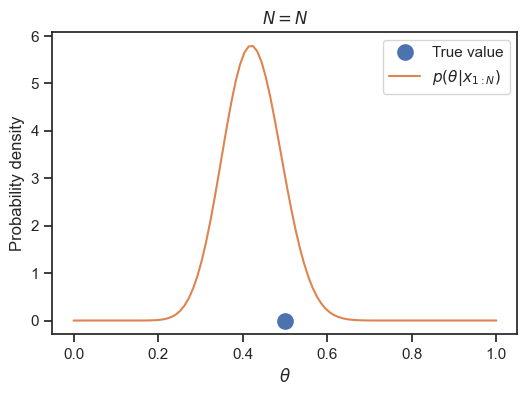

In [3]:
alpha = 1.0 + data.sum()
beta = 1.0 + N - data.sum()
Theta_post = st.beta(alpha, beta)

fig, ax = plt.subplots()
thetas = np.linspace(0, 1, 100)
ax.plot(
    [theta_true],
    [0.0],
    'o',
    markeredgewidth=2,
    markersize=10,
    label='True value')
ax.plot(
    thetas,
    Theta_post.pdf(thetas),
    label=r'$p(\theta|x_{1:N})$'
)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel('Probability density')
ax.set_title('$N={N}$')
plt.legend(loc='best');

Now that we have fitted the model, let's draw many replicated data $y^{\text{rep}}$ from the posterior predictive and compare them to the original dataset.
We are going to write a function to do this.
We will use it several times later.

In [4]:
def replicate_experiment(post_rv, n=N, n_rep=9):
    """Replicate the experiment.
    
    Arguments
    post_rv -- The random variable object corresponding to
               the posterior from which to sample.
    n       -- The number of observations.
    nrep    -- The number of repetitions.
    
    Returns:
    A numpy array of size n_rep x n.
    """
    x_rep = np.ndarray((n_rep, n), dtype="i")
    for i in range(n_rep):
        theta_post_sample = post_rv.rvs()
        x_rep[i, :] = st.bernoulli(
            theta_post_sample
        ).rvs(size=n)
    return x_rep

And here is how to use it:

In [5]:
x_rep = replicate_experiment(Theta_post)
x_rep

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 0, 1],
       [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 1, 1, 0, 1],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0

We can visualize the data as images.
The first row of pixels is are the observed data.

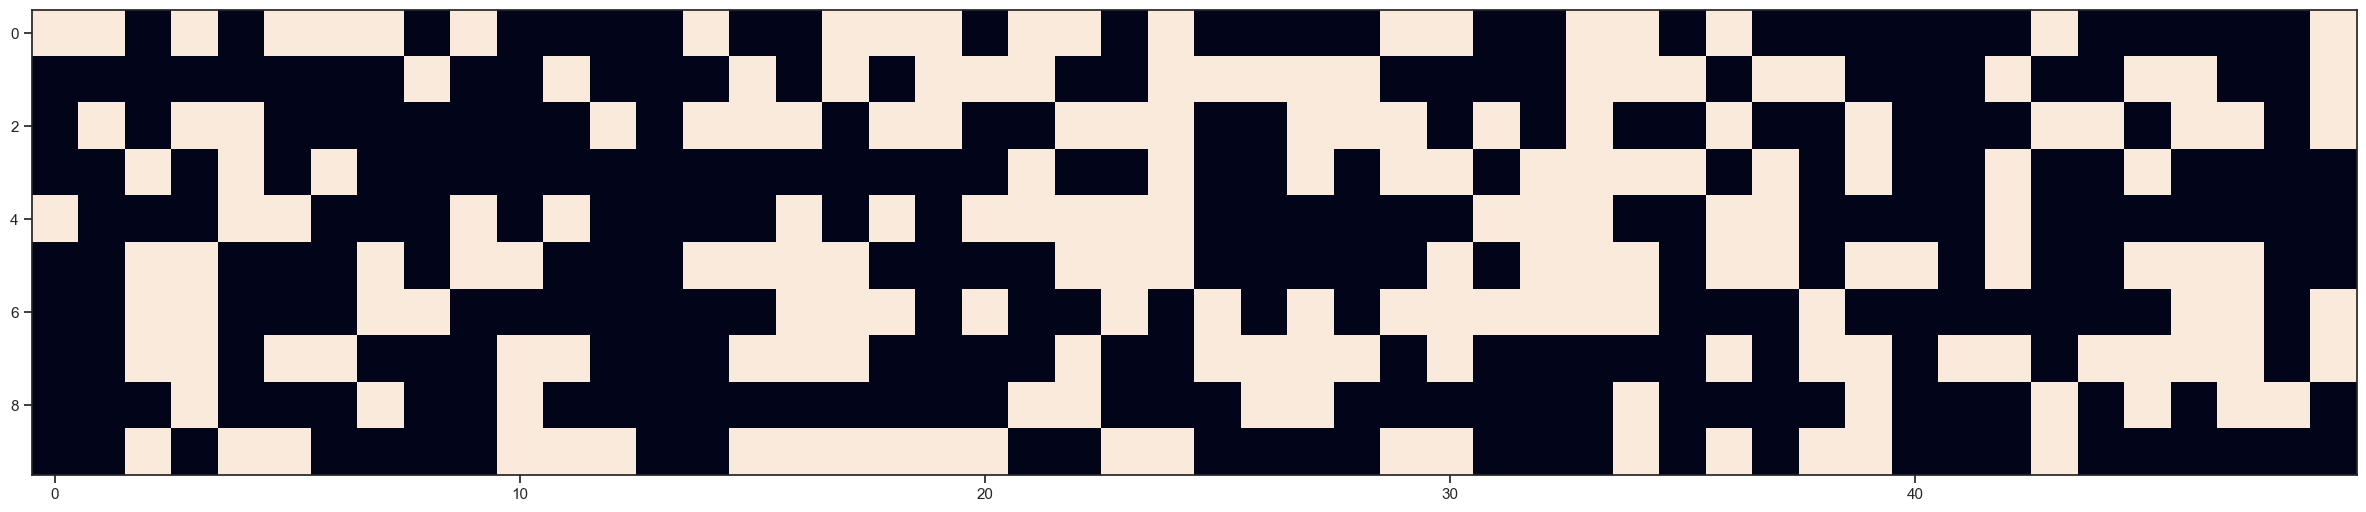

In [6]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.imshow(np.vstack([data, x_rep]));

This visual inspection does not reveal anything strange.
Let's now repeat this excersize with a dataset that is completely artificial and does not match the model.
This a dataset that I picked by hand trying to emulate a coin toss with probability of heads equal to $0.5$:

In [7]:
data_fake = np.array(
    [
        0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 0
    ]
)

Here is the posterior for this fake dataset:

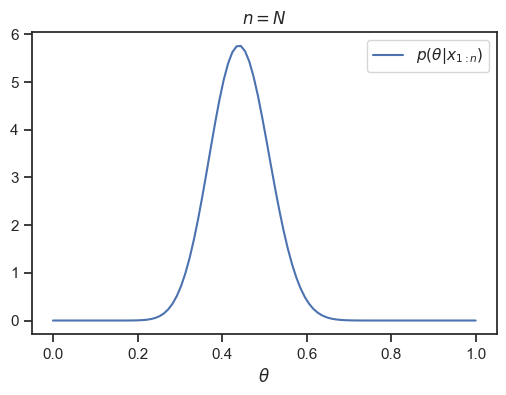

In [8]:
alpha_2 = 1.0 + data_fake.sum()
beta_2 = 1.0 + N - data_fake.sum()
Theta_2_post = st.beta(alpha_2, beta_2)

fig, ax = plt.subplots()
thetas = np.linspace(0, 1, 100)
ax.plot(
    thetas,
    Theta_2_post.pdf(thetas),
    label=r'$p(\theta|x_{1:n})$'
)
ax.set_xlabel(r'$\theta$')
ax.set_title('$n={N}$')
plt.legend(loc='best');

Let's see if the visual comparison to replicated data reveals that the data did not really come from a fair coin.

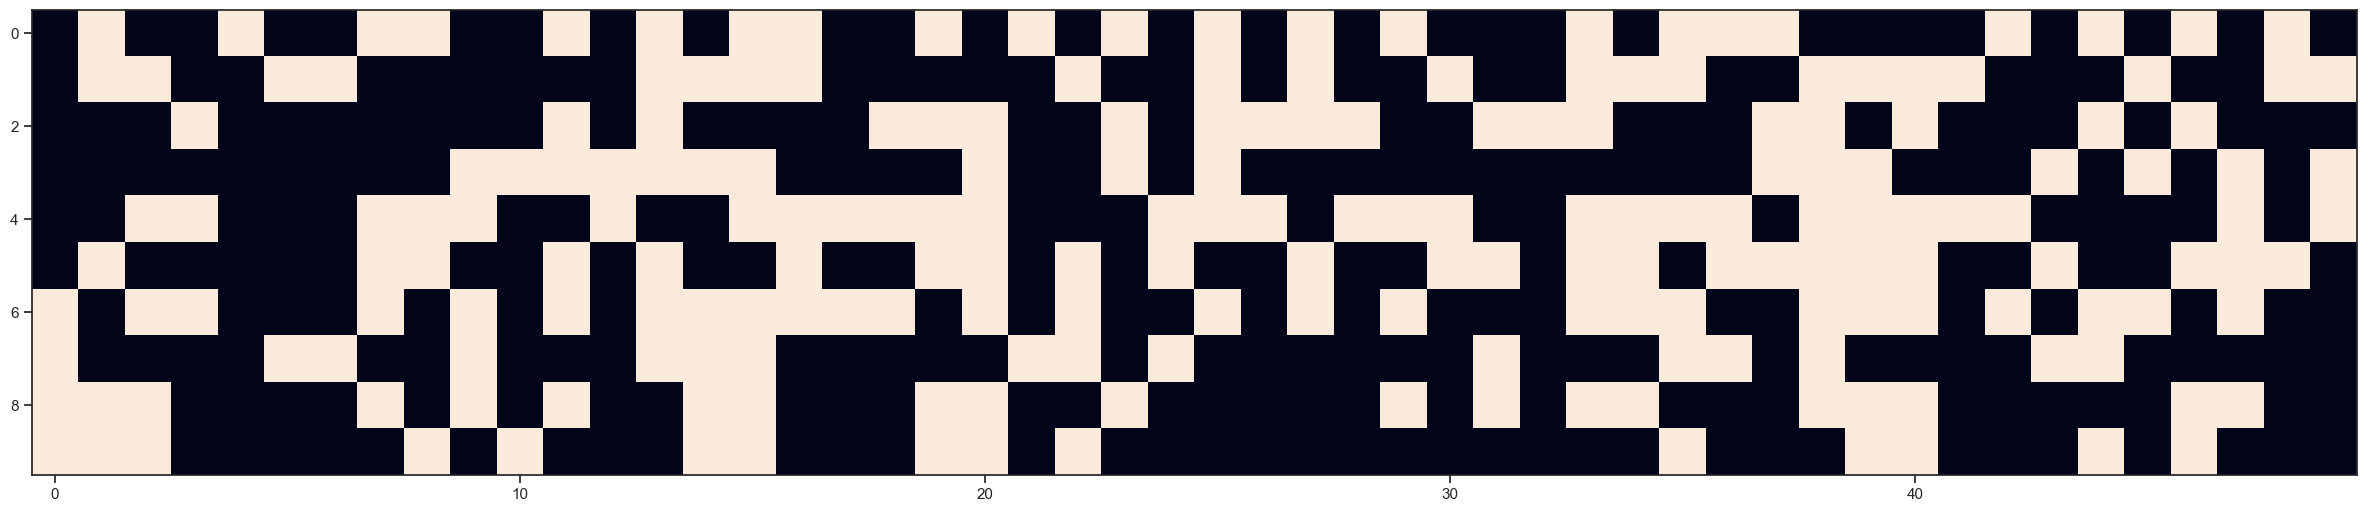

In [9]:
x_2_rep = replicate_experiment(Theta_2_post)
    
fig, ax = plt.subplots(figsize=(30, 10))
ax.imshow(np.vstack([data_fake, x_2_rep]));

If you pay close attention you will notice that the data I picked by hand has more transitions from heads to tails than the replicated data.
In other words, the replicated data seem to have longer consecutive series of either heads or tails.
How can we see this more clearly?

### Test quantities and visual inspections

We use *test quantities* to characterize the discrepancy between the model and the data.
In particular, test quantities help us zoom into the characteristsics of the data that are of particular interest to us.
Mathematically, a test quantity is a scalar function of the data and the model parameters $T(x_{1:n},\theta)$.
There are some general recipies for creating test quantities for regression and classification.
However, in general, you must use common sense in selecting them.
What are the important characteristics of the data that your model should be capturing.
We will be seeing specific examples below.

Now, assume that you have selected one, or more, test quantities.
What do you do with them?
Well, the easiest thing to do is a visual comparison of the histogram of the test quantity over replicated data, i.e., of
$p(T(x^{\text{rep}}_{1:n},\theta) | x_{1:n})$, and compare it to the observe value $T(x_{1:n},\theta)$.
In these plots you are trying to see how likely or unlikely is observed test quantity according to your model.
We will be visualizing them next for the coin toss example.

### Test quantities and Bayesian $p$-values

Antother thing that you can do to check your model is to evaluate the probability that the replicated data give you a test quantity that is more extreme than the observed value.
This probability is known as the posterior (or Bayesian) $p$-value and it is defined by:

$$
p_B = \mathbb{P}(T(x^{\text{rep}}_{1:n},\theta) > T(x_{1:n},\theta) | x_{1:n}) = \int 1_{[T(x_{1:n},\theta),\infty]}(T(x^{\text{rep}}_{1:n})) p(x^{\text{rep}}_{1:n}, \theta|x_{1:n}) dx^{\text{rep}}_{1:n}d\theta.
$$

Of course, you can just estimate the Bayesian $p$-value using Monte Carlo sampling from the joint posterior of $x^{\text{rep}}_{1:n}$ and $\theta$ conditioned on the data $x_{1:n}$.

How should I interpret the Bayesian $p$-values?
**It is not the probability that your model is correct.**
We will derive this probability in the Bayesian model selection lecture.
The Bayesian $p$-value is the probability that replications of the experiment will yield test quantitys that exceed the observed value under the assumption that your model is correct.
So, here is a nice way to interpret them:
+ A Bayesian $p$-value close to $0$ or $1$ indicates that the observed test quantity is unlikely under the assumption that your model is correct. So your model does not capture this aspect of the data. You probably need expand/modify your model somehow.

## Back to the coin toss example

What are some good test quantities that we can pick for this example.
An obvious one is the number of heads.
This is only a function of the data.
It is:

$$
T_{h}(x_{1:n}) = \sum_{i=1}^nx_i.
$$

Let's implement this as a Python function of the data:

In [10]:
def T_h(x):
    """Return the sum of x."""
    return x.sum()

Remember, that we have run this example with two datasets: one that was generated from the correct model and one that was generated by hand.
We will see the results that we get from both.

Let's put everything in a function because we are going to be using this repeatedly:

In [11]:
def perform_diagnostics(post_rv, data, test_func, n_rep=1000):
    """Calculate Bayesian p-values.
    
    Arguments
    post_rv   -- The random variable object corresponding to
                 the posterior from which to sample.
    data      -- The training data.
    test_func -- The test function.
    n         -- The number of observations.
    nrep      -- The number of repetitions.
    
    Returns a dictionary that includes the observed value of
    the test function (T_obs), the Bayesian p-value (p_val),
    the replicated test statistic (T_rep),
    and all the replicated data (data_rep).
    """
    T_obs = test_func(data)
    n = data.shape[0]
    data_rep = replicate_experiment(post_rv, n_rep=n_rep)
    T_rep = np.array(
        tuple(
            test_func(x)
            for x in data_rep
        )
    )
    p_val = (
        np.sum(np.ones((n_rep,))[T_rep > T_obs]) / n_rep
    )
    return dict(
        T_obs=T_obs,
        p_val=p_val,
        T_rep=T_rep,
        data_rep=data_rep
    )

Here is how to use it:

In [12]:
res = perform_diagnostics(
    Theta_post,
    data,
    T_h
)

T_h_obs = res["T_obs"]
p_val = res["p_val"]

print(f'The observed test quantity is {T_h_obs}')
print(f'The Bayesian p_value is {p_val:.4f}')

The observed test quantity is 21
The Bayesian p_value is 0.4610


Let's now write a function that makes a diagnostics plot:

In [13]:
def plot_diagnostics(diagnostics):
    """Make the diagnostics plot.
    
    Arguments:
    diagnostics -- The dictionary returned by perform_diagnostics()
    """
    fig, ax = plt.subplots()
    tmp = ax.hist(
        diagnostics["T_rep"],
        density=True,
        alpha=0.25,
        label='Replicated test quantity'
    )[0]
    ax.plot(
        diagnostics["T_obs"] * np.ones((50,)),
        np.linspace(0, tmp.max(), 50),
        'k',
        label='Observed test quantity'
    )
    plt.legend(loc='best');

And let's use it:

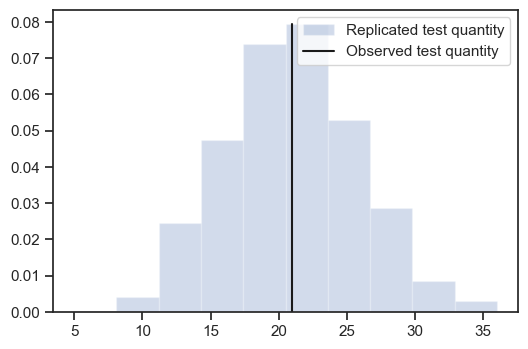

In [14]:
plot_diagnostics(res)

To save us some typing, let's combine the calculation and the plots in a single function:

In [15]:
def do_diagnostics(post_rv, data, test_func, n_rep=1000):
    """Calculate Bayesian p-values and make the corresponding
    diagnostic plot.
    
    Arguments
    post_rv   -- The random variable object corresponding to
                 the posterior from which to sample.
    data      -- The training data.
    test_func -- The test function.
    n         -- The number of observations.
    nrep      -- The number of repetitions.
    
    Returns a dictionary that includes the observed value of
    the test function (T_obs), the Bayesian p-value (p_val),
    and the replicated experiment (data_rep).
    """
    res = perform_diagnostics(
        post_rv,
        data,
        test_func,
        n_rep=n_rep
    )

    T_obs = res["T_obs"]
    p_val = res["p_val"]

    print(f'The observed test quantity is {T_obs}')
    print(f'The Bayesian p_value is {p_val:.4f}')
    
    plot_diagnostics(res)

Now, let's look also at the other dataset (the one we picked by hand):

The observed test quantity is 22
The Bayesian p_value is 0.4590


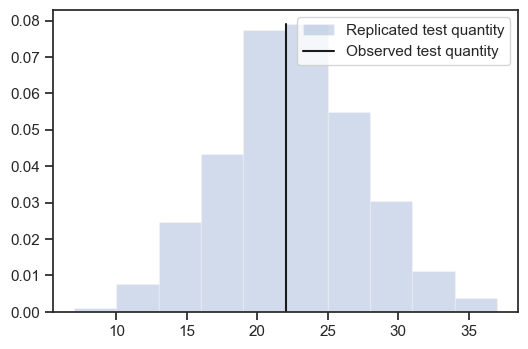

In [16]:
do_diagnostics(
    Theta_2_post,
    data_fake,
    T_h
)

It looks about the same. This just means that I was able to replicate this particular test quantity when I picked values by hand.
Can we find a better statistic?
Remember our observation when we plotted the replicated data vs the true data for the second case.
We observed that my hand-picked data included more transitions from heads to tails.
Let's build a statistic that captures that.
We are going to take this:

$$
T_s(x) = \text{# number of switches from 0 and 1 in the sequence}\;x.
$$

This is not easy to write in an analytical form, but we can program it:

In [17]:
def T_s(x):
    """Return the number of switches between 0s and 1s."""
    s = 0
    for i in range(1, x.shape[0]):
        if x[i] != x[i-1]:
            s += 1
    return s

Let's look first at the original dataset:

The observed test quantity is 24
The Bayesian p_value is 0.3970


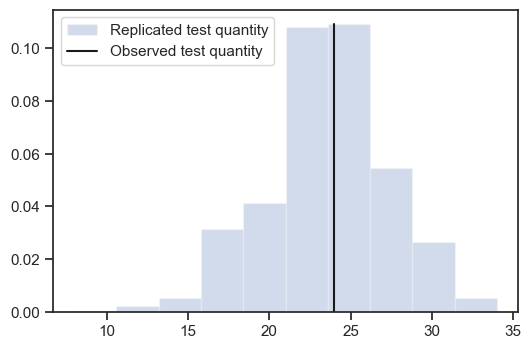

In [18]:
do_diagnostics(
    Theta_post,
    data,
    T_s
)

This looks okay. 

Let's now look at the one I picked by hand:

The observed test quantity is 36
The Bayesian p_value is 0.0000


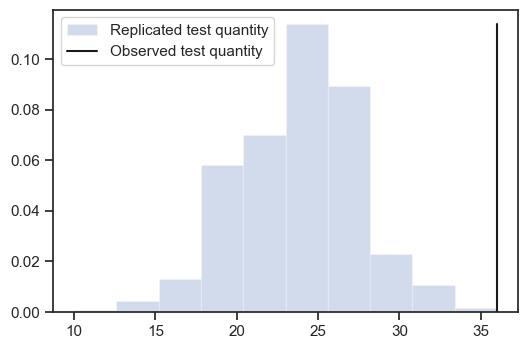

In [19]:
do_diagnostics(
    Theta_2_post,
    data_fake,
    T_s
)

The data are highly unlikely under the assumptions of this model.

## Questions
+ Rerun all the steps above with a larger number $N$ of coin toss observations.